# Convolutional Neural Networks (CNN)

## Project: Write an Algorithm for a Dog Identification App 

---
### Brief 

In this notebook, I will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, my code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

<img src="images/sample_dog_output.png" width="250">

In this real-world setting, I will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  My imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

I broke the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

## Import Libraries

In [1]:
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


---
<a id='step0'></a>
## Step 0: Import Datasets

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, I save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


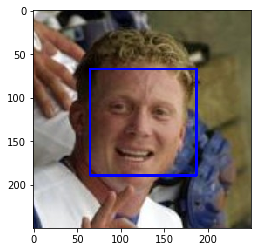

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

img = cv2.imread(human_files[1]) # load color (BGR) image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert BGR image to grayscale
faces = face_cascade.detectMultiScale(gray) # find faces in image

print('Number of faces detected:', len(faces)) # print number of faces detected in the image

# get bounding box for each detected face
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # add bounding box to color image
    
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert BGR image to RGB for plotting

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

I can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# Function: Returns "True" if face is detected in image stored at img_path

def face_detector(img_path):
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that the algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

faces_detected_human, faces_detected_dog = 0, 0

for i in range(0,100):
    
    faces_detected_human += face_detector(human_files_short[i])
    faces_detected_dog += face_detector(dog_files_short[i])
    
print('The Percentage of Faces Detected on Humans: ', faces_detected_human/100)
print('The Percentage of Faces Detected on Dogs: ', faces_detected_dog/100)   

The Percentage of Faces Detected on Humans:  0.96
The Percentage of Faces Detected on Dogs:  0.18


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

### Making Predictions with a Pre-trained Model

In the next code cell, I will write a function that accepts a path to an image (such as `'data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [6]:
VGG16 = models.vgg16(pretrained=True) # Load Models

if use_cuda:
    VGG16 = VGG16.cuda()
    
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    transform = transforms.Compose([transforms.Resize(256), # Resize 256x256
                                    transforms.CenterCrop(224), # Crop to 224×224 pixels about the center.
                                    transforms.ToTensor(), # Convert to PyTorch Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    
    image = Image.open(img_path).convert('RGB') # Load Image
    img_t = transform(image) # Transform Image
    img_t = img_t[:3,:,:].unsqueeze(0) # Add batch dimmension
    
    if use_cuda:
        img_t = img_t.cuda()
    
    output = VGG16(img_t)
    
    _, index = torch.max(output, 1)
    
    return index.item() # predicted class index

Class of this Image is: 252
Expected Class: 252 -> affenpinscher, monkey pinscher, monkey dog


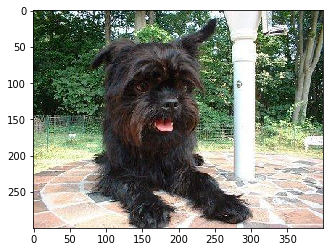

In [7]:
sample = ('data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
sample_idx = VGG16_predict(sample)
rgb_sample = Image.open(sample).convert('RGB')

plt.imshow(rgb_sample)
print('Class of this Image is:', sample_idx)
print('Expected Class: 252 -> affenpinscher, monkey pinscher, monkey dog')

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [80]:
# Function: returns "True" if a dog is detected in the image stored at img_path:

def dog_detector(img_path):
    
    index = VGG16_predict(img_path)
    is_dog = (bool(index >= 151 and index <= 268), index)
    
    return is_dog


In [9]:
#Unit Test

dog_test = dog_detector(dog_files[0])
print(dog_test)

human_test = dog_detector(human_files[0])
print(human_test)

(True, 252)
(False, 841)


# Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [10]:
dogs_in_dog_short, dogs_in_human_short = 0, 0

for i in range(0,100):
    
    dogs_in_human_short += dog_detector(human_files_short[i])[0]
    dogs_in_dog_short += dog_detector(dog_files_short[i])[0]
    
print('The Percentage of Dogs Detected on Humans: ', dogs_in_human_short, '/ 100')
print('The Percentage of Dogs Detected on Dogs: ', dogs_in_dog_short, '/ 100')   

The Percentage of Dogs Detected on Humans:  1 / 100
The Percentage of Dogs Detected on Dogs:  95 / 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, I will create a CNN that classifies dog breeds.  I must create your CNN _from scratch_ (so, I will not use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

# Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [11]:
batch_size = 32 # batch size
num_workers = 0 # number of subprocesses
num_classes = 133

#Conver to a tensor
CNN_transforms = {'transform_train': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 # Added Image Augmentation 
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ColorJitter(),
                                 transforms.RandomAffine(degrees=(-5,5),
                                                         scale=(0.9,1.1), 
                                                         translate=(0.05, 0.1)), 
                                 # https://pytorch.org/docs/stable/torchvision/transforms.html
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
              
              'transform_valid': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),                  
              

              'transform_test': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])}   

In [12]:
data_dir = 'data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

train_data = datasets.ImageFolder(train_dir, transform=CNN_transforms['transform_train'])
valid_data = datasets.ImageFolder(valid_dir, transform=CNN_transforms['transform_valid'])
test_data = datasets.ImageFolder(test_dir, transform=CNN_transforms['transform_test'])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

I applied the following Image Augmentations Techniques:

    1. Random Horizontal Flip (50%)
    2. Random Rotation - Rotate the image by angle.
    3. Color Jitter - Randomly change the brightness, contrast and saturation of an image.
    4. Random Scaling
    5. Random Translation

These transformations were applied on training dataset. The dataset is relatively large, thus it is important to diversify the data in order to prevent overfitting. Other transformations include resizing to 256x256, then cropping to 224x224 for processing.

### Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below. 

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer (sees 224x224x3 image tensor) -> Max Pooling
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1) 
        # convolutional layer (sees 112x112x16 image tensor) -> Max Pooling
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        # convolutional layer (sees 56x56x32 image tensor) -> Max Pooling
        self.conv3 = nn.Conv2d(32, 48, 3, stride=1, padding=1)
        # convolutional layer (sees 28x28x48 image tensor) -> Max Pooling
        self.conv4 = nn.Conv2d(48, 64, 3, stride=1, padding=1)
        # convolutional layer (sees 14x14x64 image tensor) -> Max Pooling
        self.conv5 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        # Final Dimension: 7x7x128 image tensor
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        ## Convololutional Layers
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))
        x = F.relu(self.pool(self.conv5(x)))
        
        # Flatten & Dropout Layers
        x = x.view(-1, 7*7*128)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [14]:
model_scratch = Net()
print(model_scratch)

if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

The following CNN is inspired by a [research paper](http://blizzard.cs.uwaterloo.ca/iss4e/wp-content/uploads/2017/10/yerbol_aussat_cs698_project_report.pdf) from the University of Waterloo, the university I am currently attending, from the CS698 course.

> "After conducting a few experiments, we came up with an architecture that is a stack of 5 convolution layers with a ReLU activation. This is our feature extractor. This feature extractor was followed by one fully-connected layer that does classification. Following the best practices for building deep neural networks, we added max-pooling and batch normalization layers after all convolutional layers. Dropout was used before the fully connected layer to help to further reduce overfitting by preventing a layer from seeing twice the exact same pattern."

The following architect outlines 5 convolution layers, followed by a dropout layer and a single fully connected layer. I have modified the network by specifying the ReLU activation funciton and a max pooling layer after each convolution. In addition I have added more fully connected layers since there is a large range of classes.

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [15]:
criterion_scratch = nn.CrossEntropyLoss() # Loss Function
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05) # Optimizer

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print("Training:")
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train() # Training Mode 
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad() # Reset Gradient
            output = model(data) # Foward Pass
            loss = criterion(output, target)  # calculate the batch loss
            loss.backward() # Backpropagation
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss)) # update training loss

        ######################    
        # validate the model #
        ######################
        model.eval() # Evaluation Mode
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
           
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

            
    # return trained model
    return model

In [17]:
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Training:
Epoch: 1 	Training Loss: 4.888435 	Validation Loss: 4.886217
Validation loss decreased (inf --> 4.886217).  Saving model ...
Epoch: 2 	Training Loss: 4.877512 	Validation Loss: 4.876875
Validation loss decreased (4.886217 --> 4.876875).  Saving model ...
Epoch: 3 	Training Loss: 4.849607 	Validation Loss: 4.789796
Validation loss decreased (4.876875 --> 4.789796).  Saving model ...
Epoch: 4 	Training Loss: 4.744267 	Validation Loss: 4.684400
Validation loss decreased (4.789796 --> 4.684400).  Saving model ...
Epoch: 5 	Training Loss: 4.661749 	Validation Loss: 4.614084
Validation loss decreased (4.684400 --> 4.614084).  Saving model ...
Epoch: 6 	Training Loss: 4.601717 	Validation Loss: 4.588594
Validation loss decreased (4.614084 --> 4.588594).  Saving model ...
Epoch: 7 	Training Loss: 4.492271 	Validation Loss: 4.443603
Validation loss decreased (4.588594 --> 4.443603).  Saving model ...
Epoch: 8 	Training Loss: 4.411963 	Validation Loss: 4.319155
Validation loss decrease

<All keys matched successfully>

### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [20]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [21]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.041162


Test Accuracy: 25% (213/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [100]:
loaders_transfer = loaders_scratch.copy()

### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [101]:
# Load the pretrained model from pytorch
model_transfer = models.resnet50(pretrained=True)
# print out the model structure
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [102]:
# Freeze training for all "features" layers 
# WE WILL ONLY TRAIN THE LAST LAYER WHICH WE WILL ADD
# SOME PRETRAINED MODELS WERE TRAINED FOR A WEEK 
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048,num_classes, bias=True)

# We will only train the last layer
for param in model_transfer.fc.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model_transfer.cuda()

In [103]:
model_transfer # New Model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

Answer: 

1. Used pre-trained Resnet50 as base model, due to its strong reputation in classifying within the ImageNet dataset.
2. Freeze all the parameters in the model. (Will not be retraining those layers)
3. Unfreeze the last layer and modify the output to the number of dog breed classes that we have.
4. Store model on GPU

### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [104]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [105]:
# train the model
model_transfer = train(50, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Training:
Epoch: 1 	Training Loss: 4.842171 	Validation Loss: 4.735003
Validation loss decreased (inf --> 4.735003).  Saving model ...
Epoch: 2 	Training Loss: 4.647475 	Validation Loss: 4.555562
Validation loss decreased (4.735003 --> 4.555562).  Saving model ...
Epoch: 3 	Training Loss: 4.474768 	Validation Loss: 4.383830
Validation loss decreased (4.555562 --> 4.383830).  Saving model ...
Epoch: 4 	Training Loss: 4.307363 	Validation Loss: 4.212102
Validation loss decreased (4.383830 --> 4.212102).  Saving model ...
Epoch: 5 	Training Loss: 4.153253 	Validation Loss: 4.058002
Validation loss decreased (4.212102 --> 4.058002).  Saving model ...
Epoch: 6 	Training Loss: 3.996216 	Validation Loss: 3.904059
Validation loss decreased (4.058002 --> 3.904059).  Saving model ...
Epoch: 7 	Training Loss: 3.848180 	Validation Loss: 3.751151
Validation loss decreased (3.904059 --> 3.751151).  Saving model ...
Epoch: 8 	Training Loss: 3.710276 	Validation Loss: 3.593274
Validation loss decrease

<All keys matched successfully>

In [106]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.164313


Test Accuracy: 82% (689/836)


In [107]:
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

print(class_names)

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog', 'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise', 'Black and tan coonhound', 'Black russian terrier', 'Bloodhound', 'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi', 'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel', 'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog', 'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso', 'Cardigan welsh corgi', 'Cavalier king charles spaniel', 'Chesapeake bay retriever', 'Chihuahua', 'Chinese crested', 'Chinese shar-pei', 'Chow chow', 'Clumber spaniel', 'Cocker spaniel', 'Collie',

In [108]:
def predict_breed_transfer(model, img_path, class_names):
    
    transform = transforms.Compose([transforms.Resize(256), # Resize 256x256
                                transforms.CenterCrop(224), # Crop to 224×224 pixels about the center.
                                transforms.ToTensor(), # Convert to PyTorch Tensor
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

    image = Image.open(img_path).convert('RGB') # Load Image
    img_t = transform(image) # Transform Image
    img_t = img_t[:3,:,:].unsqueeze(0) # Add batch dimmension
    model.eval()
    
    model = model.cpu()
    output = model(img_t)
    _, index = torch.max(output, 1)
    
    return class_names[index]

In [109]:
# Test on Images Provided:

for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    predition = predict_breed_transfer(model_transfer, img_path, class_names)
    print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))

image_file_name: ./images\American_water_spaniel_00648.jpg, 	 predition breed: Curly-coated retriever
image_file_name: ./images\Brittany_02625.jpg, 	 predition breed: Brittany
image_file_name: ./images\Curly-coated_retriever_03896.jpg, 	 predition breed: Curly-coated retriever
image_file_name: ./images\Labrador_retriever_06449.jpg, 	 predition breed: Flat-coated retriever
image_file_name: ./images\Labrador_retriever_06455.jpg, 	 predition breed: Chesapeake bay retriever
image_file_name: ./images\Labrador_retriever_06457.jpg, 	 predition breed: Labrador retriever
image_file_name: ./images\sample_cnn.png, 	 predition breed: Chihuahua
image_file_name: ./images\sample_dog_output.png, 	 predition breed: American staffordshire terrier
image_file_name: ./images\sample_human_output.png, 	 predition breed: Chinese crested
image_file_name: ./images\Welsh_springer_spaniel_08203.jpg, 	 predition breed: Welsh springer spaniel


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

![Sample Human Output](images/sample_human_output.png)


### Write your Algorithm

In [110]:
def run_app(img_path):
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()    
    
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path)[0] is True:
        prediction = predict_breed_transfer(model_transfer, img_path, class_names)
        print("Dogs Detected!\nIt looks like a {0}".format(prediction))  

    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(model_transfer, img_path, class_names)
        print("Hello, human!\nIf you were a dog. You may look like a {0}".format(prediction))
        
    else:
        prediciton = False
        print("Error! Can't detect anything.")
        
#     return prediction
    

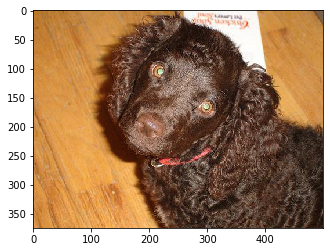

Dogs Detected!
It looks like a Curly-coated retriever


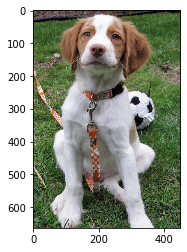

Dogs Detected!
It looks like a Brittany


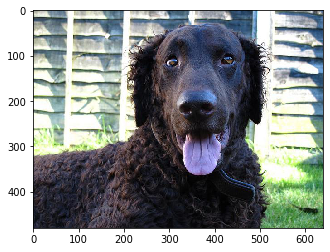

Dogs Detected!
It looks like a Curly-coated retriever


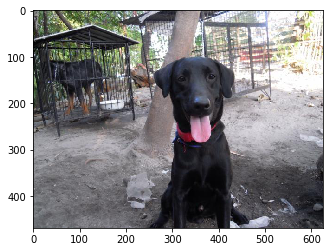

Dogs Detected!
It looks like a Flat-coated retriever


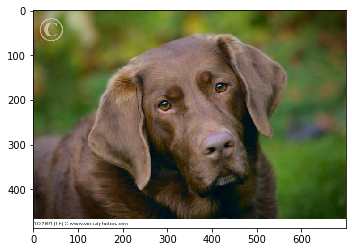

Dogs Detected!
It looks like a Chesapeake bay retriever


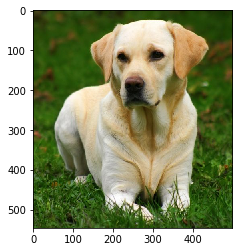

Dogs Detected!
It looks like a Labrador retriever


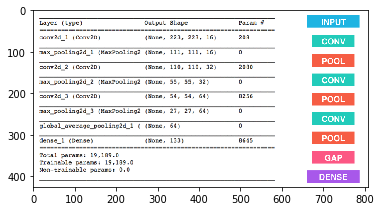

Error! Can't detect anything.


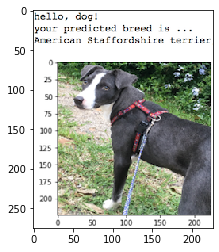

Dogs Detected!
It looks like a American staffordshire terrier


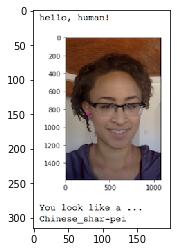

Hello, human!
If you were a dog. You may look like a Chinese crested


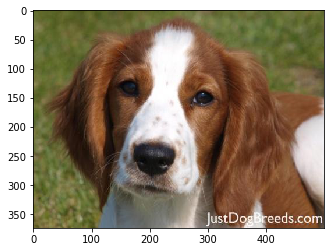

Dogs Detected!
It looks like a Welsh springer spaniel


In [111]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    run_app(img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, I will take my new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Testing my own Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

1. Train the model for a larger amount of epochs. The models were trianed with reasonable times just to meet 60% accuracy. With more epochs I am sure the model could achieve a signifigantly higher accuracy.

2. More advanced preprocessing techniques for images in order to remove background noise.

2. Tune the hyperparameters with more details: learning rate, optimizer, dropout layers, weight initialization.

In [112]:
my_human_files = ['./test_images/elon_musk.jpg', './test_images/babies.jpg', './test_images/karen.jpg' ]
my_dog_files = ['./test_images/english_bulldog.png', './test_images/rottweiler.jpg', './test_images/husly.jpg', './test_images/boss.jpg']

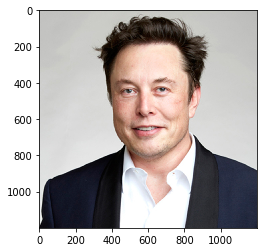

Hello, human!
If you were a dog. You may look like a Norwich terrier


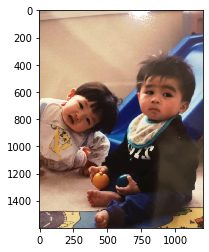

Hello, human!
If you were a dog. You may look like a Pomeranian


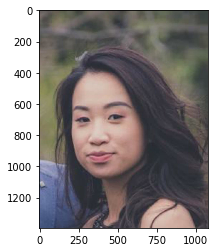

Hello, human!
If you were a dog. You may look like a Havanese


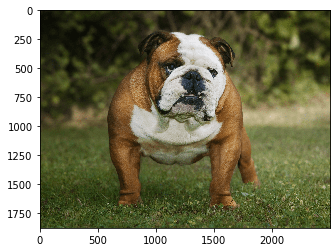

Dogs Detected!
It looks like a Boxer


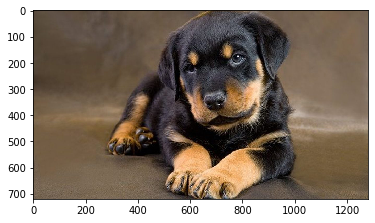

Dogs Detected!
It looks like a Beauceron


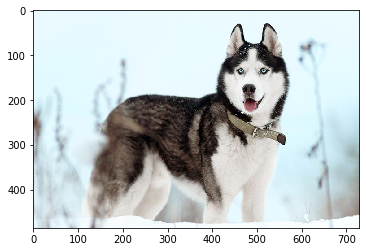

Dogs Detected!
It looks like a Alaskan malamute


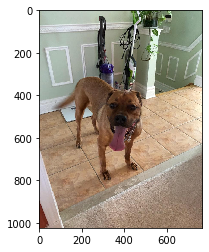

Dogs Detected!
It looks like a American staffordshire terrier


In [113]:
for file in np.hstack((my_human_files, my_dog_files)):
    run_app(file)